In [3]:
from os import path

print(path.abspath(" "))

/Users/collinsliu/jupyter/machine_learning/chapters/ 


# prepare data - mnist
1. two ways:<br>
> 1. sklearn fetch_openml <br>
> 2. download from official websites <br> arff format

## download
1. from scipy.io.arff import loadarff
2. url: 'https://www.openml.org/data/v1/download/52667/mnist_784.arff'
3. mnist_path = "../data/mnist_784.arff"
4. mnist_raw = loadarff(mnist_path)

## sklearn fetch

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784') 

In [6]:
mnist.details

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [64]:
# data description:
# X - 70000 28*28 ndarray,which is flatten into 784 (70000,784) DF
# y - 70000 labels from 0-9
X, y = mnist["data"], mnist["target"]
X.index

RangeIndex(start=0, stop=70000, step=1)

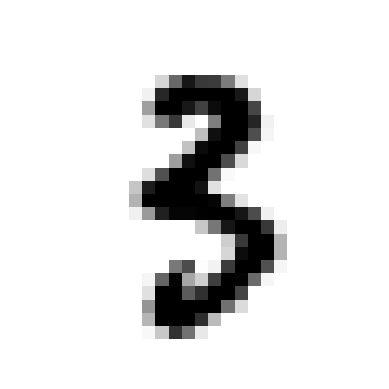

In [67]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

some_digit = X.iloc[45000]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image,  cmap=plt.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.grid(alpha=0)
plt.show()

In [69]:
y[45000]

'3'

## splitting train and test set
1. using index
2. permutation is needed - cause some ml model is order-sensitive

In [90]:
import numpy as np

np.random.RandomState(42)
shuffle_index = np.random.permutation(60000)
# again, note that X and y are stored in DF structure
X_train, X_test, y_train, y_test = X.iloc[:60000],X.iloc[60000:],y.iloc[:60000],y.iloc[60000:]
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

# train a binary classifier

In [122]:
# both numpy ndarray and pandas DataFrame allow masking
# being that sifting data with conditional judgement statement
###############################################################
# in this case, label will either be 1 or 0 denoting whether 
# digits belongs to 3 or not 3.
# note that category class will store class number as @@str@@
y_train_3 = y_train.apply(lambda x: x == '3')
y_test_3 = (y_test == "3")

In [123]:
# here we choose SGDClassifier
# numpy will automatically transfer boolean int int with following pattern
# True == 1 | False == 0
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3.apply(lambda x: int(x)))

SGDClassifier(random_state=42)

In [155]:
# sgd_clf.predict(some_digit.values.reshape(1,len(some_digit)))
sgd_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([1])

# evaluate classification result
## more controlled cross-validation
1. mannually implements cross_val_score
2. note that StratifiedKFold and KFold are mainly dealing with index
3. clone of one modle is necessary

In [171]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Stradified k-fold will split trains set and test set, but in multiple times 
# this feature is set in n_splits paramter
##############################################
# sklearn.model_selection could take DF or Se 
# yet make sure data type being made into @@int@@ or @@float@@
# not stayed in None or Object or Boolean
for train_index, test_index in skfolds.split(X_train, y_train_3.astype(int)):
    # clone is necessary
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_train_folds = y_train_3[train_index]
    y_test_fold = y_train_3[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds.apply(lambda x: int(x)))
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.6170833333333333
0.6839166666666666
0.8765833333333334
0.89375
0.7969166666666667


## typical cross validation

In [175]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3.astype(int), cv=5, scoring="accuracy")

array([0.96166667, 0.96116667, 0.95566667, 0.92058333, 0.96166667])

## accuracy problem
1. accuracy is not always the best evaluation measurement
2. for classification problems, more scoring methods are needed
3. confusion matrix will provide accuracy over different categories

In [188]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

sgd_clf_3 = SGDClassifier()
y_train_pred = cross_val_predict(sgd_clf_3, X_train, y_train_3.astype(int), cv=5)
confusion_matrix(y_train_3.astype(int),y_train_pred)

array([[52079,  1790],
       [ 1121,  5010]])

<table style="text-align:center;">
    <tr>
        <th></th>
        <th>pred non-3-class 0</th>
        <th>pred 3-class 1</th>
    </tr>
    <tr>
        <td>real non-3-class 0</td>
        <td>true non-3-class 0</td>
        <td>false positive</td>
    </tr>
    <tr>
        <td>real 3-class 1</td>
        <td>false negative</td>
        <td>true 3-class 1</td>
    </tr>
</table>

$$ important \space score 
\left\{
\begin{aligned}
    Precision & = & \frac{True \space Positive}{all \space Predicit \space 1s} & \\
    Recall & = & \frac{True \space Positive}{all \space Real \space 1s} & \\
    F1 & = & \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}
\end{aligned}
\right .
$$ 

In [190]:
from sklearn.metrics import precision_score, recall_score, f1_score
# y_train_pred could only return result of one fold, which may not 
# show the gerenral result of this model
precision_score(y_train_3.astype(int), y_train_pred)

0.736764705882353

In [185]:
recall_score(y_train_3.astype(int),y_train_pred)

0.7959549828739194

In [191]:
f1_score(y_train_3.astype(int), y_train_pred)

0.7748820663521769

In [192]:
print(y_train_pred.shape)

(60000,)


In [199]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# precision_recall will take two params
# first is the true labels, for methods to decide label assignments
# second is the prediction scores of SGDClassifier
y_scores = cross_val_predict(sgd_clf_3, X_train, y_train_3.astype(int),cv = 3,
                            method="decision_function")
precision, recalls, threshold = precision_recall_curve(y_train_3.astype(int), y_scores)

In [217]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],
             color="blue",ls='--',lw=1,label="Precision")
    plt.plot(thresholds, recalls[:-1],
             color="purple",ls='-',lw=1,label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.grid(alpha=0.4)
    plt.ylim([0,1])
    plt.xlim([-55000,55000])

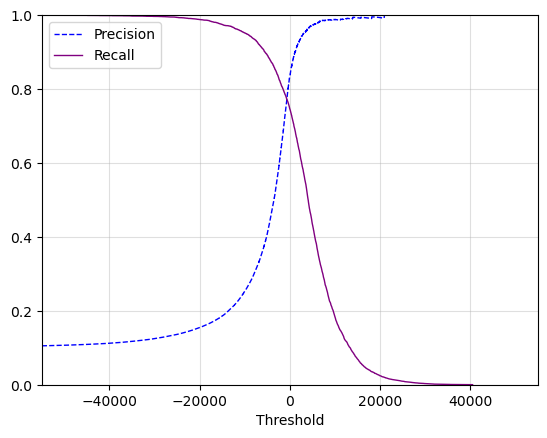

In [218]:
plot_precision_recall(precision, recalls, threshold)

# train a multiclass classifier
1. SGDClassifier could detect a OvA training need - show trainig score is <font color=sapphire><b>decision_function</b></font> attribute
2. else, use sklearn.multiclass OneVsOneClassifier - <font color=sapphire><b>estimators_ attribute</b></font> will show each underlying estimator
3. other classifier could do multiclass classification

In [224]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array(['3'], dtype='<U1')

In [228]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-12805.21344507,  -9967.00941184, -15558.49998346,
          5765.90042806, -16865.92438783,  -4708.69151147,
        -18032.00812999, -20288.67041754,  -6549.30075024,
         -7635.75022887]])

In [229]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [234]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42,shuffle=True))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array(['3'], dtype=object)

In [237]:
some_digit_score_ovo = ovo_clf.decision_function([some_digit])
some_digit_score_ovo

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([[1.66666723, 3.66666828, 4.66666906, 9.33333309, 2.66666701,
        7.33333298, 0.66666696, 1.66666754, 8.33333302, 4.33332902]])

## RandomForest - OVO classifier

In [249]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train.astype(int))
forest_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([3])

In [261]:
forest_proba = forest_clf.predict_proba([some_digit])
forest_cla = forest_clf.classes_
for cla, proba in zip(forest_cla, forest_proba.flatten()):
    print(cla, ": ", proba)

0 :  0.0
1 :  0.0
2 :  0.0
3 :  0.94
4 :  0.0
5 :  0.02
6 :  0.0
7 :  0.0
8 :  0.01
9 :  0.03


/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## evaluate model & tweak model params
for evaluating validility of model, we should note that cross_val would not change model itself, also does confusion matrix
1. use sklearn.model_selection cross_val_score
2. use sklearn.model_selection cross_val_predict
2. use sklearn.metrics confusion_matrix

In [264]:
from sklearn.model_selection import cross_val_score

cross_val_score(forest_clf,X_train, y_train.astype(int),cv=5, scoring="accuracy")

array([0.96633333, 0.96591667, 0.96991667, 0.9665    , 0.96908333])

In [266]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train.astype(int),cv=5, scoring='accuracy')

array([0.96691667, 0.965     , 0.96925   , 0.96808333, 0.96908333])

In [268]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=5)
conf_mat = confusion_matrix(y_train ,y_train_pred)
conf_mat

array([[5851,    1,   11,    3,    4,    7,   13,    1,   29,    3],
       [   1, 6639,   36,   15,   11,    6,    7,   12,   10,    5],
       [  18,   13, 5769,   33,   25,    5,   16,   37,   35,    7],
       [   6,    8,   76, 5829,    3,   61,    9,   48,   64,   27],
       [  10,   10,   12,    1, 5669,    0,   22,   10,   15,   93],
       [  19,    4,    8,   72,    7, 5207,   47,    3,   31,   23],
       [  24,   10,    3,    0,    8,   43, 5816,    0,   14,    0],
       [   4,   24,   61,    5,   37,    0,    0, 6057,   11,   66],
       [   9,   32,   31,   40,   21,   42,   24,    3, 5577,   72],
       [  21,   10,   12,   74,   66,   18,    3,   57,   44, 5644]])

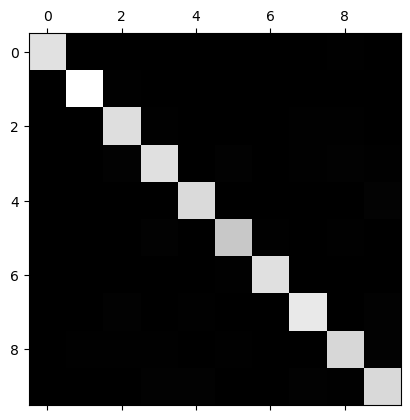

In [278]:
plt.matshow(conf_mat, cmap=plt.get_cmap("gray"))

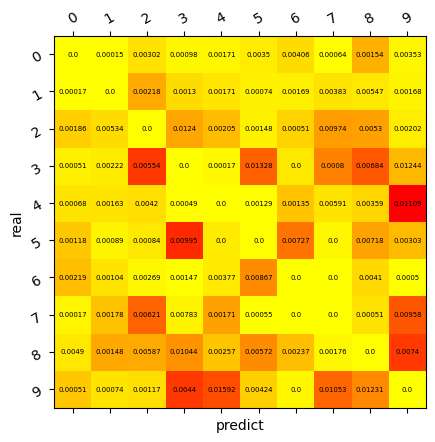

In [328]:
norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.get_cmap('autumn_r'))
plt.xticks(range(len(norm_conf_mat)),np.arange(0,10,1),rotation=30)
plt.yticks(range(len(norm_conf_mat[0])),np.arange(0,10,1),rotation=30)
plt.xlabel("predict")
plt.ylabel('real')
for x_pos, val in enumerate(norm_conf_mat):
    for y_pos , vals in enumerate(val):
        plt.text(x_pos, y_pos, np.round(vals,5),
                 va='center',ha='center',fontsize=5)

## investige each error pair
finding out that 4 - 9 pair has more biases
1. by picking out corresponding position

In [393]:
#定义显示一张图片的函数
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image,cmap=plt.cm.binary,
              interpolation="nearest")
    plt.axis("off")
#定义显示多张图片
def plot_digits(instances,images_per_row=10,**options):
    size=28
    #每行有几个
    images_per_row=min(len(instances),images_per_row)
    images=instances.values.reshape(len(instances),size,size).tolist()
    #有几行
    n_rows=(len(instances)-1)//images_per_row+1
    row_images=[]
    n_empty=n_rows*images_per_row-len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        #每次添加一行
        rimages=images[row*images_per_row:(row+1)*images_per_row]
        # 对添加的每一行的图片左右连接
        row_images.append(np.concatenate(rimages,axis=1))
    # 对添加的每一列图片 上下连接
    image=np.concatenate(row_images,axis=0)
    plt.imshow(image,cmap=plt.cm.binary, **options)
    plt.axis("off")

(140, 140)
(140, 140)
(140, 140)
(140, 140)


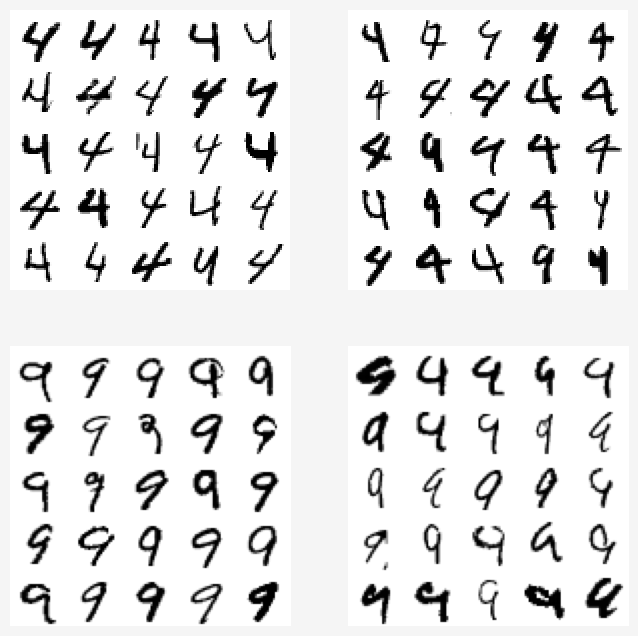

In [365]:
cl_a, cl_b = "4", "9"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

fig, ax = plt.subplots(2,2,figsize=(8,8),
                       facecolor='whitesmoke',
                       edgecolor='gray')
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_bb[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_ba[:25],images_per_row=5)

# multilabel classifier
1. KNeighborsClassifier could support multilabel classifier
2. the usage is create label contains multilabels, which is usually a np array

In [379]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype(int) >= 7) # class larger than 7 
y_train_odd = (y_train.astype(int) % 2 == 1) # class number is odd
y_multilabel = np.concatenate((y_train_large.values.reshape(len(y_train_large),1), 
                               y_train_odd.values.reshape(len(y_train_odd),1)), axis=1)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [378]:
# some_digit is class 3, which should be [False, True]
knn_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

## evaluation via f1
1. f1 score could count in multi-label manner, with average param needed

In [381]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train.astype(int), cv=5)

NameError: name 'f1_score_knn' is not defined

In [382]:
f1_score(y_train.astype(int),y_train_knn_pred, average="macro")

0.9702339666388221

# multioutput classifier
 this could be a little tricky, we regard each pixel as one label, and pixel intensities as classes(0-255) of each label, thus we could have 784 labels per picture in mnist dataset.

In [386]:
# first, adding noises to original mnist dataset
# when using len to numpy nd array or even pandas DF, it will always return how many rows it would have
# in other words, len() will alwasy return first dimension
rnd = np.random.RandomState(42)
train_noise = rnd.randint(0,100,(len(X_train),784))
test_noise = rnd.randint(0,100,(len(X_test),784))
X_train_mod = X_train + train_noise
X_test_mod = X_test + test_noise
y_train_mod = X_train
y_test_mod = X_test

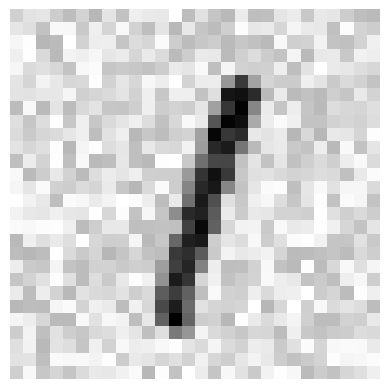

In [398]:
some_index = 5
plot_digit(X_test_mod.iloc[some_index].values)

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


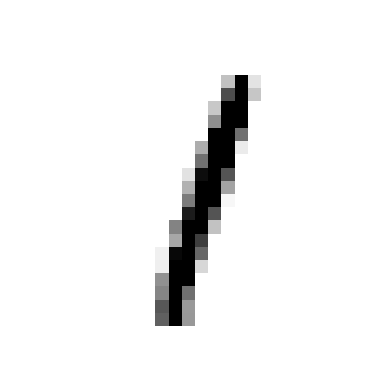

In [397]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)